# Frequency & Severity GLMs for Auto Insurance

This notebook builds GLMs for claim **frequency** and **severity**, then combines
them into a pure premium estimate as required in the MA 326 project.  We use
driver, vehicle, territory, and claims-history factors as predictors.


# Frequency & Severity GLMs for Auto Insurance

This notebook builds GLMs for claim **frequency** and **severity**, then combines
them into a pure premium estimate as required in the MA 326 project.  We use
driver, vehicle, territory, and claims-history factors as predictors.


In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

# Load pre-cleaned dataset
df = pd.read_csv("motor_cleaned.csv")

print("Loaded cleaned dataset:")
df.head()


Loaded cleaned dataset:


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Age,Severity
0,1,05/11/2015,05/11/2015,05/11/2016,1956-04-15,20/03/1976,0,4,1,2,...,2004,80,599,7068.0,0,P,NaN,190,68,NaN
1,1,05/11/2015,05/11/2016,05/11/2017,1956-04-15,20/03/1976,0,4,1,2,...,2004,80,599,7068.0,0,P,NaN,190,68,NaN
2,1,05/11/2015,05/11/2017,05/11/2018,1956-04-15,20/03/1976,0,4,2,2,...,2004,80,599,7068.0,0,P,NaN,190,68,NaN
3,1,05/11/2015,05/11/2018,05/11/2019,1956-04-15,20/03/1976,0,4,2,2,...,2004,80,599,7068.0,0,P,NaN,190,68,NaN
4,2,26/09/2017,26/09/2017,26/09/2018,1956-04-15,20/03/1976,0,4,2,2,...,2004,80,599,7068.0,0,P,NaN,190,68,NaN


# Predictor Selection

In [129]:
# Select predictors for both frequency and severity
predictors = [
    "Age", "N_claims_history", "R_Claims_history", "Power", "Value_vehicle"
]

# Frequency: use full dataset (do NOT drop rows). Build a predictors-based design matrix
y_freq = df["N_claims_year"].fillna(0)
# Candidate frequency predictors (numeric + categorical if present)
freq_numeric = ['Age', 'Power', 'Value_vehicle', 'N_claims_history', 'R_Claims_history']
freq_cat = ['Type_fuel', 'Area', 'Type_risk', 'Distribution_channel', 'Second_driver']
present_cat = [c for c in freq_cat if c in df.columns]
X_freq = df[freq_numeric + present_cat].copy()
# One-hot encode present categorical predictors and drop first to avoid multicollinearity
if present_cat:
    X_freq = pd.get_dummies(X_freq, columns=present_cat, drop_first=True)
# Convert boolean dummies to numeric and coerce non-numeric to numeric, then fill NA with 0
X_freq = X_freq.replace({True: 1, False: 0})
X_freq = X_freq.apply(pd.to_numeric, errors='coerce').fillna(0)
# Add constant for GLM
X_freq = sm.add_constant(X_freq, has_constant='add')

# Severity: keep original predictors and drop rows missing predictors or severity
df_sev = df[predictors + ["Severity"]].dropna()
cat_cols = ["Type_fuel", "Area", "Type_risk"]
# Use numeric predictors (including Age) — don't try to one-hot columns that aren't in df_sev
X_sev = df_sev[predictors].copy()
y_sev = df_sev["Severity"]

# Note: frequency model uses all policies; severity uses only policies with observed Severity


/tmp/ipykernel_58812/4097735722.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_freq = X_freq.replace({True: 1, False: 0})


# Diagnostics

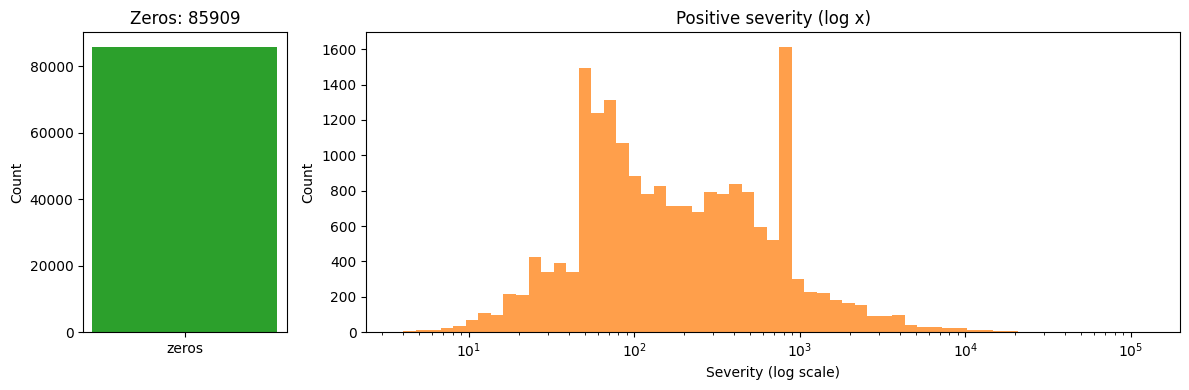

In [130]:
# Diagnostic: show shapes and simple distribution diagnostics for frequency and severity
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plot raw severity including zeros with improved scaling

# Use full dataframe Severity (NaN -> 0) so zeros are included
sev_all = df['Severity'].fillna(0)
zeros = int((sev_all == 0).sum())
pos = sev_all[sev_all > 0]
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 4]})
# Left: zeros count
axes[0].bar(0, zeros, width=0.6, color='C2')
axes[0].set_xticks([0])
axes[0].set_xticklabels(['zeros'])
axes[0].set_ylabel('Count')
axes[0].set_title(f'Zeros: {zeros}')

# Right: positive severities on log x-axis
if len(pos) > 0:
    bins = np.logspace(np.log10(pos.min()), np.log10(pos.max()), 60)
    sns.histplot(pos, bins=bins, kde=False, color='C1', ax=axes[1])
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Severity (log scale)')
    axes[1].set_title('Positive severity (log x)')
else:
    axes[1].text(0.5, 0.5, 'No positive severities', ha='center', va='center')

plt.tight_layout()
plt.show()

# Train/Test Split (40/60)

In [131]:
# Train/Test Split (40/60): frequency uses full dataset; severity uses df_sev subset
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_freq, y_freq, train_size=0.4, random_state=42
)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_sev, y_sev, train_size=0.4, random_state=42
)


# Frequency Model

In [132]:
# Frequency model: intercept-only design (Xf_train contains an Intercept column)
print(Xf_train.dtypes)
print(yf_train.dtype)

# Convert to plain NumPy float arrays
Xf_train_np = Xf_train.to_numpy(dtype=float)
Xf_test_np  = Xf_test.to_numpy(dtype=float)
yf_train_np = yf_train.to_numpy(dtype=float)
yf_test_np  = yf_test.to_numpy(dtype=float)

# Fit Poisson GLM
freq_model = sm.GLM(yf_train_np, Xf_train_np, family=sm.families.Poisson())
freq_res   = freq_model.fit()
print(freq_res.summary())

overdispersion = freq_res.deviance / freq_res.df_resid
print("Overdispersion ratio (Poisson):", overdispersion)

# Predictions on test set
freq_pred_test = freq_res.predict(Xf_test_np)
print(freq_pred_test[:10])


const                     float64
Age                         int64
Power                       int64
Value_vehicle             float64
N_claims_history            int64
R_Claims_history          float64
Type_fuel_P                 int64
Area_1                      int64
Type_risk_2                 int64
Type_risk_3                 int64
Type_risk_4                 int64
Distribution_channel_1      int64
Second_driver_1             int64
dtype: object
int64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                42222
Model:                            GLM   Df Residuals:                    42209
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32091.
Date:                Mon, 01 Dec 2025   Deviance:               

# Severity Model

In [133]:
# Add constant
Xs_train_const = sm.add_constant(Xs_train)
Xs_test_const  = sm.add_constant(Xs_test)

print(Xs_train_const.dtypes)
print(ys_train.dtype)

# Convert to plain NumPy arrays (float)
Xs_train_np = Xs_train_const.to_numpy(dtype=float)
Xs_test_np  = Xs_test_const.to_numpy(dtype=float)
ys_train_np = ys_train.to_numpy(dtype=float)
ys_test_np  = ys_test.to_numpy(dtype=float)

# Gamma needs strictly positive y
mask_sev_pos = ys_train_np > 0
Xs_train_np_pos = Xs_train_np[mask_sev_pos]
ys_train_np_pos = ys_train_np[mask_sev_pos]

# Quick winsorization: cap the positive severities at the 99.5th percentile to reduce outlier influence
if len(ys_train_np_pos) > 0:
    cap_pct = 99.5
    cap_val = np.percentile(ys_train_np_pos, cap_pct)
    ys_train_np_pos_w = np.minimum(ys_train_np_pos, cap_val)
    print(f'Winsorizing positives at {cap_pct}th pct -> cap={cap_val:.2f} (training positives: {len(ys_train_np_pos)})')
else:
    ys_train_np_pos_w = ys_train_np_pos.copy()

# Fit Gamma GLM with log link on winsorized positives
sev_model = sm.GLM(
    ys_train_np_pos_w,
    Xs_train_np_pos,
    family=sm.families.Gamma(link=sm.families.links.log())
)
sev_res = sev_model.fit()
print(sev_res.summary())

# Predict on full Xs_test (predictions for zeros are just model output; downstream logic may treat zeros separately)
sev_pred_test = sev_res.predict(Xs_test_np)
print(sev_pred_test[:10])

const               float64
Age                   int64
N_claims_history      int64
R_Claims_history    float64
Power                 int64
Value_vehicle       float64
dtype: object
float64
Winsorizing positives at 99.5th pct -> cap=7508.30 (training positives: 7858)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7858
Model:                            GLM   Df Residuals:                     7852
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          3.5348
Method:                          IRLS   Log-Likelihood:                -56778.
Date:                Mon, 01 Dec 2025   Deviance:                       13375.
Time:                        19:07:43   Pearson chi2:                 2.78e+04
No. Iterations:                    14   Pseudo R-squ. (CS):           0.008905
Covariance Type:     

/home/toivo/ma326-project/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


# Model Metrics

In [134]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Metrics (use the same test vectors used to train with NumPy)
print("Frequency MSE:", mean_squared_error(yf_test_np, freq_pred_test))
print("Frequency MAE:", mean_absolute_error(yf_test_np, freq_pred_test))

print("Severity MSE:", mean_squared_error(ys_test_np, sev_pred_test))
print("Severity MAE:", mean_absolute_error(ys_test_np, sev_pred_test))

Frequency MSE: 168.67593956498516
Frequency MAE: 0.6345687757466965
Severity MSE: 2519750.648472435
Severity MAE: 462.62006468722296


# Pure Premium Modelling

freq shapes -> obs: (63333,) pred: (63333,)
Frequency MSE: 168.67593956498516
Frequency MAE: 0.6345687757466965
severity shapes -> obs: (11788,) pred: (11788,)
Severity MSE: 2519750.648472435
Severity MAE: 462.62006468722296
Pure premium predictions (first 10):
[105.31545749 114.50335177  63.23384189 250.31696303  74.7520231
  85.49881531 104.24843367  80.79509136 106.57238634 182.41165528]
0    105.315457
1    114.503352
2     63.233842
3    250.316963
4     74.752023
Name: PurePremium, dtype: float64


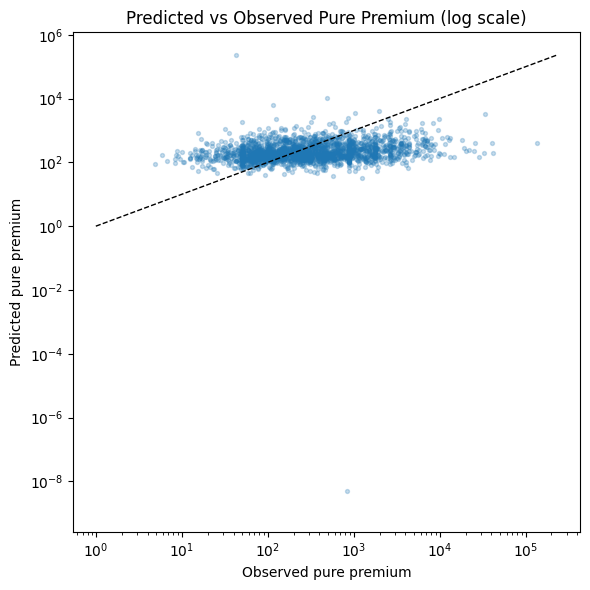

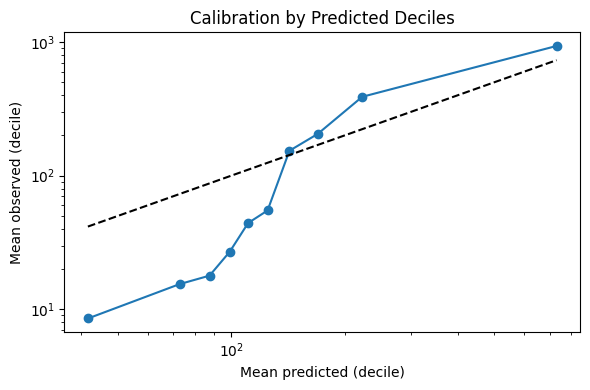

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure predictions and observations are 1-D numpy arrays .ravel converts an array to a 1-D array (flattening)
yf_obs = np.asarray(yf_test_np).ravel()
freq_pred = np.asarray(freq_pred_test).ravel()

# Frequency: align shapes (we take the minimum length if they differ)
print('freq shapes -> obs:', yf_obs.shape, 'pred:', freq_pred.shape)
if yf_obs.shape[0] != freq_pred.shape[0]:
    m = min(yf_obs.shape[0], freq_pred.shape[0])
    print(f'Warning: frequency arrays length mismatch, truncating to {m}')
    yf_obs = yf_obs[:m]
    freq_pred = freq_pred[:m]

print("Frequency MSE:", mean_squared_error(yf_obs, freq_pred))
print("Frequency MAE:", mean_absolute_error(yf_obs, freq_pred))

# Severity: align shapes and handle positives vs zeros
ys_obs = np.asarray(ys_test_np).ravel()
sev_pred = np.asarray(sev_pred_test).ravel()

print('severity shapes -> obs:', ys_obs.shape, 'pred:', sev_pred.shape)
if ys_obs.shape[0] == sev_pred.shape[0]:
    # direct comparison (predictions include zeros or model predicted for full Xs_test)
    sev_mse = mean_squared_error(ys_obs, sev_pred)
    sev_mae = mean_absolute_error(ys_obs, sev_pred)
    print("Severity MSE:", sev_mse)
    print("Severity MAE:", sev_mae)
else:
    # If lengths differ, try to compute metrics on positive test cases only. This is because sev_pred_test was
    #trained only on positive ys_train cases, so sev_pred_test may only contain predictions for positive test rows
    #This avoids comapring model outputs intended for positive cases against observed zeros
    mask_pos = ys_obs > 0
    if mask_pos.sum() == sev_pred.shape[0]:
        print('Detected sev_pred only for positive test rows; computing metrics on positives only')
        sev_mse = mean_squared_error(ys_obs[mask_pos], sev_pred)
        sev_mae = mean_absolute_error(ys_obs[mask_pos], sev_pred)
        print("Severity MSE (positives only):", sev_mse)
        print("Severity MAE (positives only):", sev_mae)
    else:
        # If arrays cannot be aligned, the code truncates to the minimum length as done earlier with frequency
        m = min(ys_obs.shape[0], sev_pred.shape[0])
        print(f'Warning: severity arrays length mismatch and could not align; truncating to {m}')
        sev_mse = mean_squared_error(ys_obs[:m], sev_pred[:m])
        sev_mae = mean_absolute_error(ys_obs[:m], sev_pred[:m])
        print("Severity MSE (truncated):", sev_mse)
        print("Severity MAE (truncated):", sev_mae)

# Pure premium prediction: frequency × severity (align lengths first)
pp_obs_len = min(freq_pred.shape[0], sev_pred.shape[0])
pure_premium_pred = freq_pred[:pp_obs_len] * sev_pred[:pp_obs_len]

print("Pure premium predictions (first 10):")
print(pure_premium_pred[:10])

# Make as labeled Series (use pandas)
import pandas as pd
pure_premium_series = pd.Series(pure_premium_pred, name="PurePremium")
print(pure_premium_series.head())

# Plot
# align lengths

pp_len = min(len(freq_pred), len(sev_pred), len(yf_obs), len(ys_obs))
pred_pp = np.asarray(pure_premium_pred)[:pp_len]
obs_pp  = np.asarray(yf_obs)[:pp_len] * np.asarray(ys_obs)[:pp_len]

plt.figure(figsize=(6,6))
plt.scatter(obs_pp, pred_pp, s=8, alpha=0.25)
minv = max(1, min(obs_pp.min(), pred_pp.min()))
maxv = max(obs_pp.max(), pred_pp.max())
plt.xscale('log'); plt.yscale('log')
plt.plot([minv, maxv], [minv, maxv], 'k--', linewidth=1)  # perfect-fit line
plt.xlabel('Observed pure premium')
plt.ylabel('Predicted pure premium')
plt.title('Predicted vs Observed Pure Premium (log scale)')
plt.tight_layout()
plt.show()

dfpp = pd.DataFrame({'obs': obs_pp, 'pred': pred_pp})
dfpp['decile'] = pd.qcut(dfpp['pred'].rank(method='first'), 10, labels=False)
grp = dfpp.groupby('decile').agg(obs_mean=('obs','mean'), pred_mean=('pred','mean'), n=('obs','size'))
plt.figure(figsize=(6,4))
plt.plot(grp['pred_mean'], grp['obs_mean'], '-o')
plt.plot([grp['pred_mean'].min(), grp['pred_mean'].max()],
         [grp['pred_mean'].min(), grp['pred_mean'].max()], 'k--')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Mean predicted (decile)')
plt.ylabel('Mean observed (decile)')
plt.title('Calibration by Predicted Deciles')
plt.tight_layout()
plt.show()